# Point Net Overview

Point Net is a flexible architecture that allows for classification or semantic segmentation of point clouds.

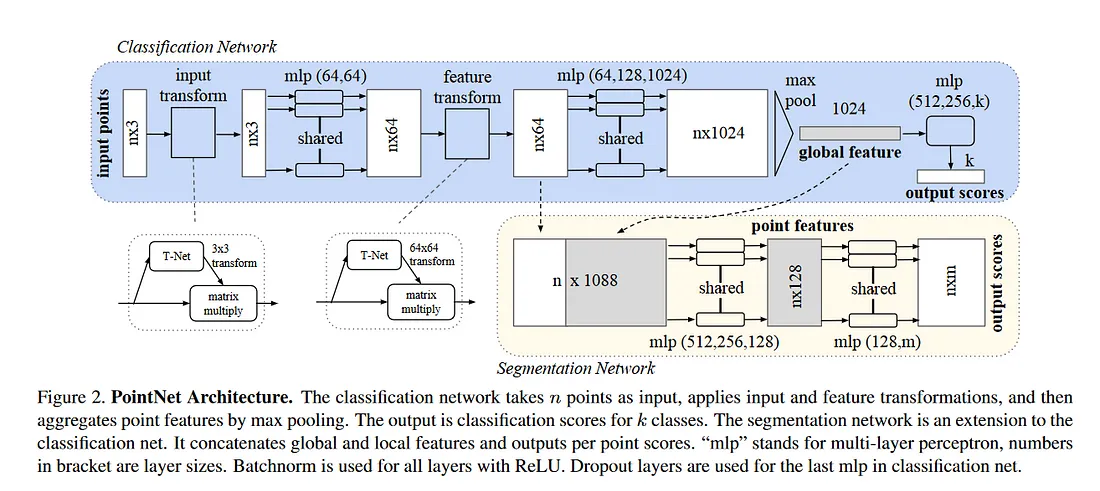

The Point Net architecture is directly able to consume point clouds, the architecture is outlilned above.

Point Net takes in a 3D pointcloud of n points (Nx3). A point cloud doesn't have any order but they do have an orientation and position (note that regardless of the orientation and position the overall structure of the point cloud will remain same). To make the Point Net invarient to the orientation of the input point cloud we utilize these mini networks called T-nets.  

# T-Nets

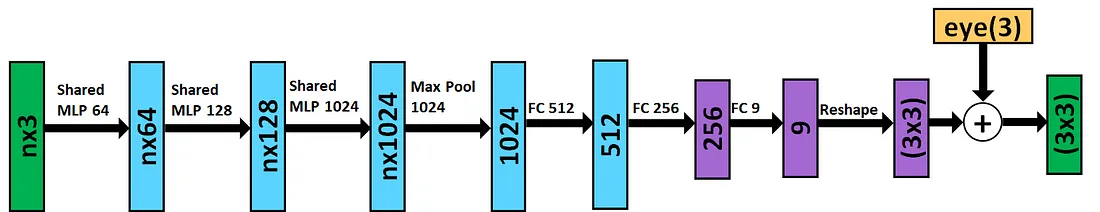

A T-net is a specific Neural Network that learns a transformation matrix that will rotate the input point cloud to a consistent orientation. As mentioned above this is to ensure that the network is invarient to the point clouds orientation. In the forward pass the input point cloud is multiplied by the learned transformation matrix. This enables Point Net to learn in an end-to-end fashion on many different representatoins of point clouds. It learns to orient the input point clouds before it performs feature extraction.

If you refer to the first figure we see that there are two T-nets. The first T-net transforms the input point cloud before any feature extraction has taken place. After this first transformation the features are scaled up to 64 with a shared MLP, after which the feature extraction takes place by the second T-net. This transform is performed on the 64 dimensional features to obtain the Local features.


Architecture

The first portion is a series of shared MLPs followed by a Max Pool and a few FC Layers. After the final Fc layer the output is reshaped into a matrix and the identity matrix is added to it. The identity matrix is an orthogonal matrix that will return the same point that it's multiplied against. Here we are essentially initializing the output of the T-net with the identity Matrix. This is done for stability.

The following class can be used for T-nets in input space and in the 64 dimensional space.

In [1]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Setting up the T net class
class Tnet(nn.Module):
  ''' T-Net learns a transformation matrix with a specified dimension'''
  def __init__(self, dim, num_points = 2500):
    super(Tnet, self).__init__()

    # Dimensions for transform matrix
    self.dim = dim

    self.conv1 = nn.Conv1d(dim, 64, kernel_size = 1)
    self.conv2 = nn.Conv1d(64, 128, kernel_size =1)
    self.conv3 = nn.Conv1d(128, 1024, kernel_size =1)

    self.linear1 = nn.Linear(1024, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, dim**2) # This allows the class to be used for both input spaces

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)

    self.max_pool = nn.MaxPool1d(kernel_size = num_points)

  def forward(self, x):
    bs = x.shape[0]

    # pass through shared MLP layers (conv1d)
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))

    # max pool over num points
    x = self.max_pool(x).view(bs, -1)
    '''.view(bs , -1) flattens the output of the maxpool from a 3D tensor [bs, num_channels, 1] to
    a 2d tensor [bs, num_features]. The -1 tells PyTorch to calculate the total number of rows
    to ensure that the number of elements is consistent.
    '''

    # Pass through the MLP
    x = self.bn4(F.relu(self.linear1(x)))
    x = self.bn5(F.relu(self.linear2(x)))
    x = self.linear3(x)

    # initialize the identity matrix
    iden = torch.eye(self.dim, requires_grad = True).repeat(bs ,1, 1)

    if x.is_cuda:
      iden = iden.cuda()

    x = x.view(-1, self.dim, self.dim) + iden # reshaping output to a matrix

    return x


Shared MLPs are implemented as 1D convolutions, since convolutions naturally allow for weight sharing.

# Coding the backbone

The backbone consists of everything except the classification/segmentation head

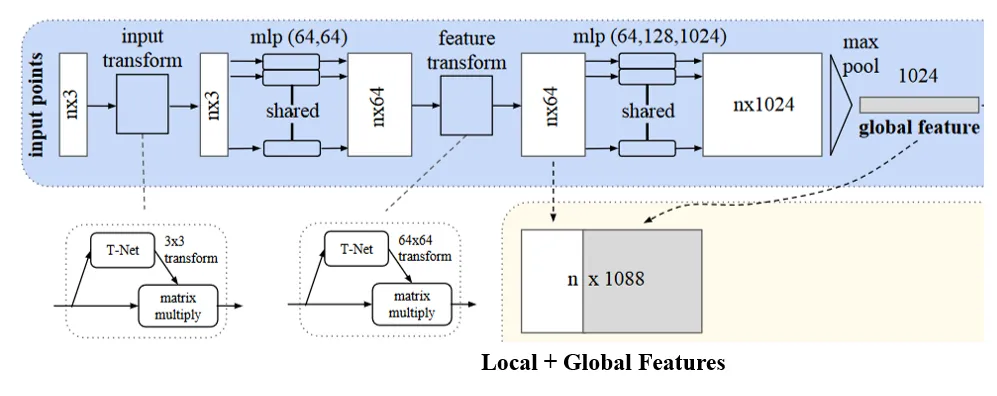

This backbone either returns Global Features (in the case of classification) or concatenated local and global features (in the case of segmentation). the number of global features in the paper was 1024 but this can be changed if required.

We will be including the argument  `local_feat` in the backbone class that allows the `forward()` function to return either global or concatenated local and global features when set to True. This will determine whether the backbone is used for segmentation or classification.

Along with the features the forward function will return the critical point index locations and the feature transformation matrix. this matrix is used as a regularization term that will help it become orthogonal. An orthogonal transformation perserves the lengths of vectors and angles between them.

In [3]:
# Point Net Backbone
class PointNetBackbone(nn.Module):
  def __init__(self, num_points = 2500, num_global_feats = 1024, local_feat = True):
    super(PointNetBackbone, self).__init__()

    # if true concat local and global features
    self.num_points = num_points
    self.num_global_feats = num_global_feats
    self.local_feat = local_feat

    # spatial transformer network (T-Net)
    self.tnet1 = Tnet(dim = 3, num_points = num_points)
    self.tnet2 = Tnet(dim = 64, num_points = num_points)

    # Shared MLP 1
    self.conv1 = nn.Conv1d(3, 64, kernel_size =1)
    self.conv2 = nn.Conv1d(64, 64, kernel_size =1)

    # Shared MLP 2
    self.conv3 = nn.Conv1d(64, 64, kernel_size =1)
    self.conv4 = nn.Conv1d(64, 128, kernel_size =1)
    self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size = 1)

    # batch norms for both shared mlps
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(64)
    self.bn3 = nn.BatchNorm1d(64)
    self.bn4 = nn.BatchNorm1d(128)
    self.bn5 = nn.BatchNorm1d(self.num_global_feats)


    # Max pool to get the global features
    # We can visualize them by getting the max pool func to return the indices by setting return_indices = True
    self.max_pool = nn.MaxPool1d(kernel_size= num_points, return_indices = True)

  def forward(self, x):

    # get batch size
    bs = x.shape[0]

    # pass through first Tnet to get transform matrix
    A_input = self.tnet1(x)

    # perform first transformation across each point in the batch
    x = torch.bmm(x.transpose(2, 1), A_input).transpose(2,1)

    # pass through first shared MLP
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))

    # get feature transform
    A_feat = self.tnet2(x)

    # perform second transformation across each (64 dim) features in the batch
    x = torch.bmm(x.transpose(2,1), A_feat).transpose(2,1)

    # store local point features for segmentation head
    local_features = x.clone()

    # pass through second MLP head
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))

    # get global feature vector and critial indexes
    global_features, critical_indexes = self.max_pool(x)
    global_features = global_features.view(bs, -1)
    critical_indexes = critical_indexes.view(bs, -1)

    if self.local_feat:
      features = torch.cat((local_features, global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), dim =1)
      return features, critical_indexes, A_feat
    else:
      return global_features, critical_indexes, A_feat

# Coding the Classification Head

The classification head is just another series of shared MLPs that will learn output scores for each class. The input is simply the learned Global Features.


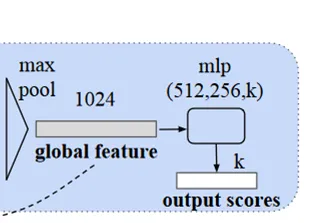

In [4]:
# Classification head
class PointNetClassHead(nn.Module):
  '''Classification Head'''
  def __init__(self, num_points = 2500, num_global_feats = 1024, k =2):
    super(PointNetClassHead, self).__init__()

    # get the backbone (require only global features for classification)
    self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat = False)

    # MLP for classification
    self.linear1 = nn.Linear(num_global_feats, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, k)

    # batchnorm for the first 2 linear layers
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(256)

    # the paper says only batchnorm is added to the layers before the classification layer
    # but another version uses dropouts for the first 2 layers as well
    self.dropout = nn.Dropout(p = 0.3)

  def forward(self, x):
    # get global features
    x, crit_idxs, A_feat = self.backbone(x)
    x = self.bn1(F.relu(self.linear1(x)))
    x = self.bn2(F.relu(self.linear2(x)))
    x = self.dropout(x)
    x = self.linear3(x)

    return x, crit_idxs, A_feat

# Coding the segmentation head
the segmentation head of Point Net takes in the concatenation of the learned local and global features providing it a rich representation of the input point cloud. The architecture is shown below.

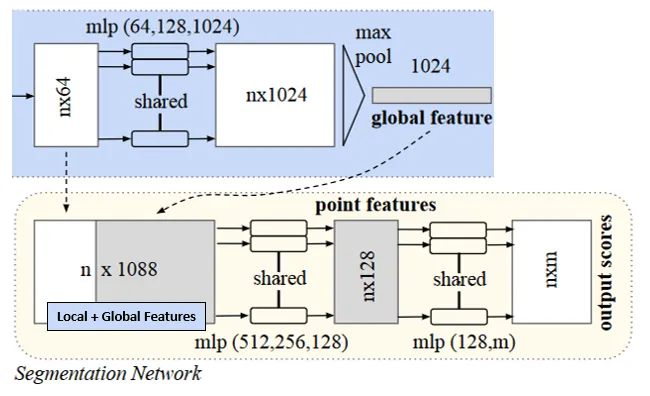

At the input the global features are repeated n times when concatenated with local features. The architecture is straightforward, a series of shared MLPs that maintain the original n dimensions, and the final layer projects each point to m possible classes.

In [5]:
# Segmentation head
class PointNetSegHead(nn.Module):
  '''Segmentation Head'''
  def __init__(self, num_points = 2500, num_global_feats = 1024, m =2):
    super(PointNetSegHead, self).__init__()

    self.num_points = num_points

    # get the backbone
    self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat = True)

    # Shared MLP
    num_features = num_global_feats + 64 # local and global features
    self.conv1 = nn.Conv1d(num_features, 512, kernel_size =1)
    self.conv2 = nn.Conv1d(512, 256, kernel_size =1)
    self.conv3 = nn.Conv1d(256, 128, kernel_size =1)
    self.conv4 = nn.Conv1d(128, m, kernel_size =1)

    # batch norm for shared MLP
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(256)
    self.bn3 = nn.BatchNorm1d(128)

  def forward(self, x):

    # get combined features
    x, crit_idxs, A_feat = self.backbone(x)

    # pass through shared MLP
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.conv4(x)

    x = x.transpose(2,1)
    return x, crit_idxs, A_feat

# Testing out the code

In [6]:
def main():
  test_data = torch.rand(32, 3, 2500)

  # test T_net
  tnet = Tnet(dim =3)
  transform = tnet(test_data)
  print(f'T-net output shape: {transform.shape})')

  ## test backbone
  pointfeat = PointNetBackbone(local_feat = False)
  out, _, _ = pointfeat(test_data)
  print(f'Backbone output shape: {out.shape}')

  pointfeat = PointNetBackbone(local_feat = True)
  out, _, _ = pointfeat(test_data)
  print(f'Combined Feature shape: {out.shape}')

  # test on single batch (should throw error if there is an issue)
  pointfeat = PointNetBackbone(local_feat = True).eval()
  out, _, _ = pointfeat(test_data[0, :, :].unsqueeze(0))

  # test classification head
  classifier = PointNetClassHead(k=5)
  out, _, _ = classifier(test_data)
  print(f'Class output shape: {out.shape}')

  classifier = PointNetClassHead(k=5).eval()
  out, _, _ = classifier(test_data[0, :, :].unsqueeze(0))

  ## test segmentation head
  seg = PointNetSegHead(m=3)
  out, _, _ = seg(test_data)
  print(f'Seg shape: {out.shape}')


if __name__ == '__main__':
    main()

T-net output shape: torch.Size([32, 3, 3]))
Backbone output shape: torch.Size([32, 1024])
Combined Feature shape: torch.Size([32, 1088, 2500])
Class output shape: torch.Size([32, 5])
Seg shape: torch.Size([32, 2500, 3])
